<a href="https://colab.research.google.com/github/ojasnadkar96/cs273p_project/blob/master/decisionTree_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree (PCA)

Importing all the required libraries.

In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

The two functions below are to save and import pickle files.<br>

In [0]:
def save_pkl(df,name):
    fullname = name+'.pkl'
    output = open(fullname, 'wb')
    pickle.dump(df, output)
    output.close()

In [0]:
def import_pkl(df,name):
    fullname = name+'.pkl'
    df = pickle.load(open(fullname, 'rb'))
    return df

In [0]:
df_train = pd.DataFrame()
df_valid = pd.DataFrame()
df_test = pd.DataFrame()
df_train_l = pd.DataFrame()
df_valid_l = pd.DataFrame()
df_test_l = pd.DataFrame()

In [0]:
df_train = import_pkl(df_train,'train_x')
df_valid = import_pkl(df_valid,'valid_x')
df_test = import_pkl(df_test,'test_x')
df_train_l = import_pkl(df_train_l,'train_x_l')
df_valid_l = import_pkl(df_valid_l,'valid_x_l')
df_test_l = import_pkl(df_test_l,'test_x_l')

In [0]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)
print(df_train_l.shape)
print(df_valid_l.shape)
print(df_test_l.shape)

(77854, 168)
(13737, 168)
(10175, 168)
(77854, 1)
(13737, 1)
(10175, 1)


Pre-processed data with a total of 168 features has been imported into dataframes.<br>
We will apply PCA on these datasets to reduce the dimensionality of this data.<br>

In [0]:
from sklearn.decomposition import PCA
dims = []
variances = []
optimum_dim = 168
threshold=0.01
for dim in range(1, 168):
    pca = PCA(n_components=dim)
    pca.fit(df_train)
    variance = np.array(pca.explained_variance_ratio_)
    variance = variance.min()
    if threshold < variance:
        optimum_dim = dim
        dims.append(dim)
        variances.append(variance)
    else:
        break

24


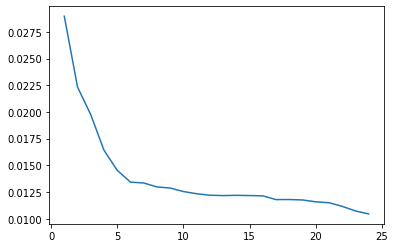

In [0]:
print(optimum_dim)
import matplotlib.pyplot as plt
plt.plot(dims, variances)
plt.show()

Optimal value for PCA is 24 features, as we can see in the graph above.

In [0]:
pca = PCA(n_components=24)
pca_train = pca.fit_transform(df_train)
print(pca.explained_variance_ratio_)

[0.0289579  0.0223335  0.01973839 0.01649176 0.01473801 0.01351811
 0.01336496 0.0130119  0.01288753 0.01253714 0.01236023 0.01217972
 0.01216768 0.01214592 0.0121261  0.01206825 0.01205461 0.01198407
 0.01187219 0.01168075 0.01165696 0.01150346 0.01082444 0.01072806]


We have now reduced the train dataset into 24 features using PCA.

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score

In [0]:
from sklearn.tree import DecisionTreeClassifier
DecTree1 = DecisionTreeClassifier(random_state=0)
DecTree1.fit(pca_train,np.ravel(df_train_l))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [0]:
train_score = DecTree1.score(pca_train,np.ravel(df_train_l))
print(train_score*100)

99.99614663344208


The accuracy for training data after PCA for Decision Tree is around 99.99%

In [0]:
pca_valid = pca.transform(df_valid)
valid_score = DecTree1.score(pca_valid,np.ravel(df_valid_l))
print(valid_score*100)

44.340103370459346


The accuracy for validation data after PCA for Decision Tree is around 44.34%<br>
High training score but low validation score is an indication of overfitting, so we now look at hyperparameters.<br>

In [0]:
from pprint import pprint
pprint(DecTree1.get_params())

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}


Above are the parameters being used in Decision tree classifier.<br>

In [0]:
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
max_depth = [10,20,30,40,50]
max_depth.append(None)
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 6, 10]}


Now, we take a set of values for each parameter and pass them through RandomizedCV for 25 iterations.<br>
This should give us a good range of better parameters.<br>

In [0]:
from sklearn.model_selection import PredefinedSplit
train_len = len(pca_train)
valid_len = len(pca_valid)
pca_tv = np.concatenate((pca_train,pca_valid), axis=0)
df_tv_l = pd.concat([df_train_l, df_valid_l], ignore_index = True)
bound = np.array([(i < train_len) * -1 for i in range(train_len + valid_len)])
split = PredefinedSplit(bound)

In the RandomizedCV model, we define a custom split for validation.<br>
Our validation data is being used as the cross-validation split for RandomizedCV.<br>

In [0]:
DecTree2 = DecisionTreeClassifier()
DecTree_random = RandomizedSearchCV(estimator = DecTree2, param_distributions = random_grid, n_iter = 100, n_jobs = 2, verbose = 1, cv = split)

DecTree_random.fit(pca_tv,np.ravel(df_tv_l))

DecTree_random.best_params_

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   57.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.8min finished


{'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10}

Out of the randomly given parameter values, above values give the best score.

In [0]:
DecTree3 = DecisionTreeClassifier(class_weight='balanced',
 min_samples_split=6,
 min_samples_leaf=1,
 max_features='auto',
 max_depth=10)
DecTree3.fit(pca_train,np.ravel(df_train_l))
Train_score = DecTree3.score(pca_train,np.ravel(df_train_l))
print(Train_score*100)

40.76219590515581


In [0]:
Valid_score = DecTree3.score(pca_valid,np.ravel(df_valid_l))
print(Valid_score*100)

34.694620368348254


This score of RandomizedSearchCV can be improved by GridSearchCV. We perform GridSearchCV on a range of parameters around the above obtained best parameters.

In [0]:
from sklearn.model_selection import GridSearchCV

max_features = ['auto']
max_depth = [10,15,20]
max_depth.append(None)
min_samples_split = [4,5,6]
min_samples_leaf = [2, 3]

search_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(search_grid)

{'max_depth': [10, 15, 20, None],
 'max_features': ['auto'],
 'min_samples_leaf': [2, 3],
 'min_samples_split': [4, 5, 6]}


In [0]:
DecTree4 = DecisionTreeClassifier()
DecTree_grid = GridSearchCV(estimator = DecTree4, param_grid = search_grid, n_jobs = 2, verbose = 1, cv = split)
DecTree_grid.fit(pca_tv, np.ravel(df_tv_l))

DecTree_grid.best_params_

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:   36.3s finished


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6}

Now, we find the final scores of the model by training it with the best parameters obtained above.

In [0]:
DecTree_final = DecisionTreeClassifier(max_depth=10, max_features='auto', min_samples_leaf=2, min_samples_split=3)
DecTree_final.fit(pca_train, np.ravel(df_train_l))
Train_score = DecTree_final.score(pca_train, np.ravel(df_train_l))
print('Final Train score: ',Train_score*100)

Final Train score:  56.70871117733193


In [0]:
Valid_score = DecTree_final.score(pca_valid,np.ravel(df_valid_l))
print('Final Validation score: ',Valid_score*100)

Final Validation score:  53.54153017398268


In [0]:
pca_test = pca.transform(df_test)
Test_score = DecTree_final.score(pca_test,np.ravel(df_test_l))
print('Final Test Score: ', Test_score*100)

Final Test Score:  53.356265356265354


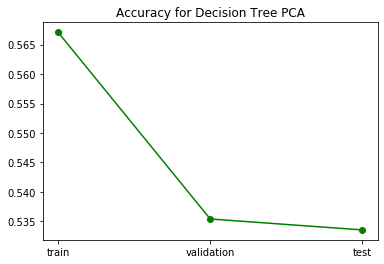

In [0]:
scores = [Train_score, Valid_score, Test_score]
labels = ['train','validation','test']
plt.title("Accuracy for Decision Tree PCA")
plt.plot(labels, scores, marker='o', color = "g", label = "Final model scores")
plt.show()